# Project 1 - Microlensing 1
# Brandon Shane, Ina Park, Toshan Vysyraju, Arya Lakshmanan

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import emcee
import corner

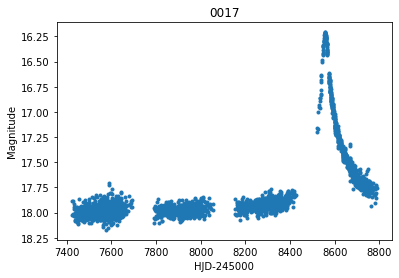

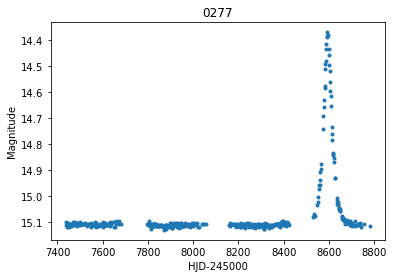

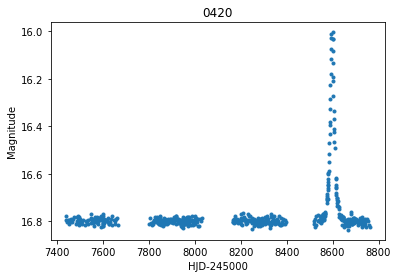

In [2]:
# _locs = ['OGLE-2019-BLG-/blg-0017/',]
Data = {}
names = ['0017','0277','0420']

for name in names:
    d = np.loadtxt('OGLE-2019-BLG-'+name+'/blg-'+name+'/phot.dat', dtype=float)
    x = d[:,0] - 245e4
    y = d[:,1]
    
    plt.scatter(x, y, marker = '.')
    plt.gca().invert_yaxis()
    plt.title(name)
    plt.xlabel('HJD-245000')
    plt.ylabel('Magnitude')
    plt.show()

    
    Data[name] = d

In [3]:
def xi(param):
    'X^2 to mininize to find parameters'
    #m_bl being the baseline magnitude
    umin,tE, m_bl, t_0 = param 
    
    u = np.sqrt(umin**2 + ((x-t_0)/tE)**2)
    A = u**2 + 2
    A /= (u*np.sqrt((u**2)+4))
    #m_mod refers to m observed as predicted by our model 
    m_mod = m_bl - 2.5*np.log10(A)
    
    if (tE < 1 or umin < 1e-4):
        return 1e8
    tot = 0
    for i in range(len(y)):
        tot += ((y[i] - m_mod[i])**2)/s[i]**2 
    return tot

In [4]:
# Creating lists of parameters to call later in emcee
uminlist = []
tElist = []
m_bllist = []
t_0list = []

Optimization terminated successfully.
         Current function value: 64760.065746
         Iterations: 423
         Function evaluations: 718
[2.20723201e-01 1.10380878e+02 1.79616886e+01 8.55529618e+03]


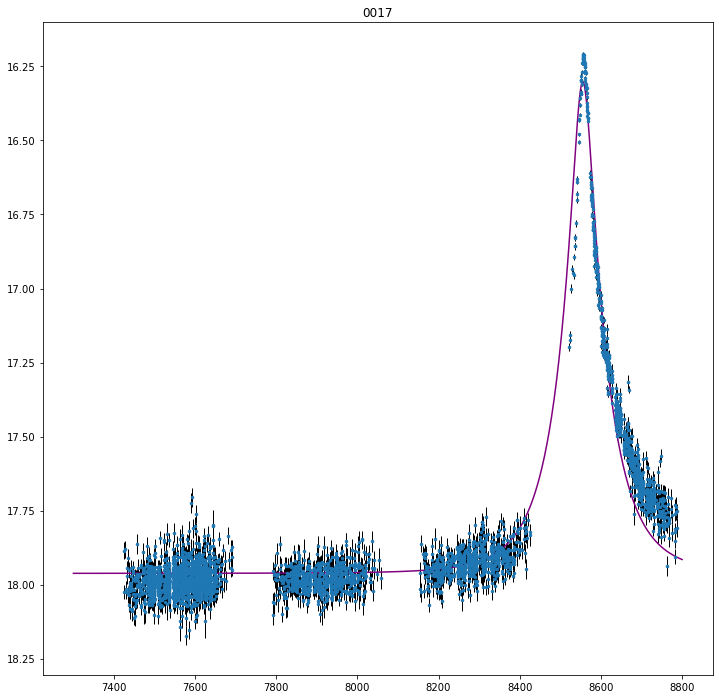

Optimization terminated successfully.
         Current function value: 1894.523544
         Iterations: 413
         Function evaluations: 713
[5.65472488e-01 2.69589893e+01 1.51116645e+01 8.59362412e+03]


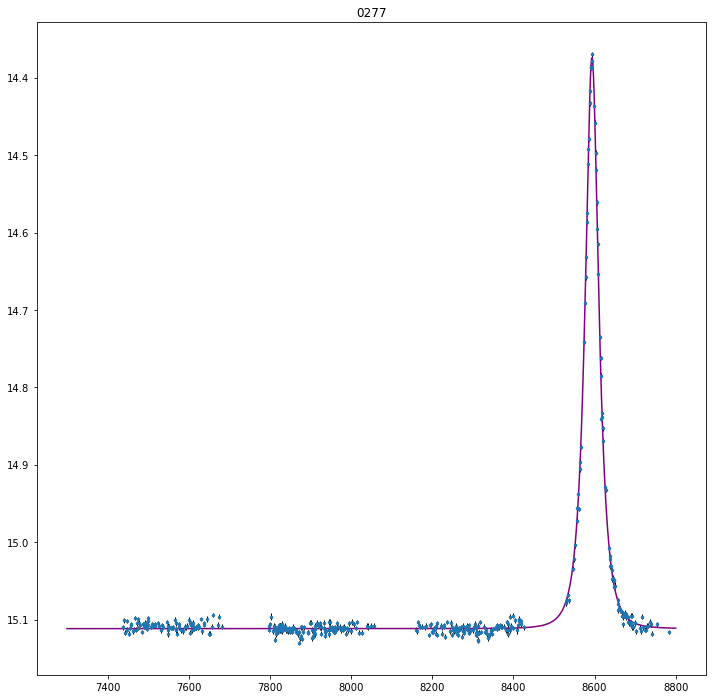

Optimization terminated successfully.
         Current function value: 1172.420696
         Iterations: 444
         Function evaluations: 753
[5.03713794e-01 1.28511612e+01 1.67951332e+01 8.59702758e+03]


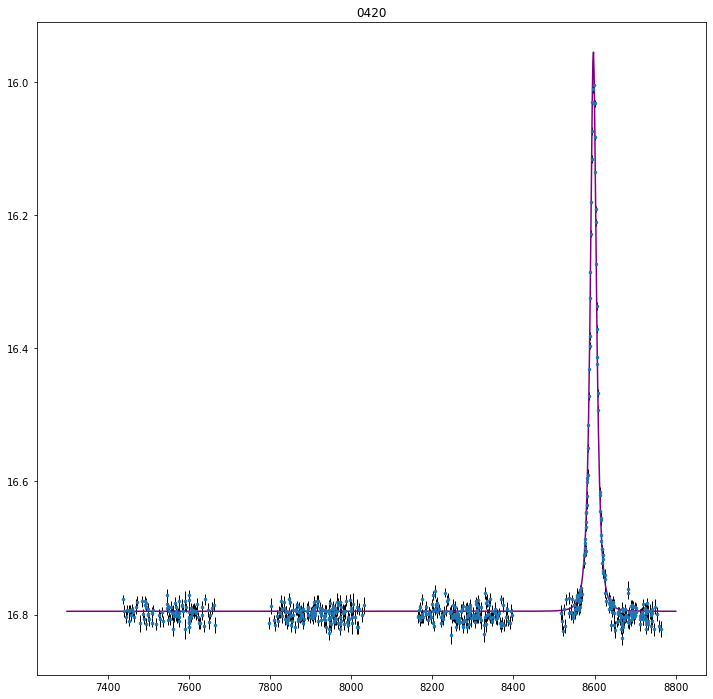

In [5]:
for name in Data.keys():
    d = Data[name]
    x = d[:,0] - 245e4
    y = d[:,1]
    s = d[:,2]
    

    # change the size of the plot to a square
    plt.rcParams["figure.figsize"] = (12, 12)
    
    
    # Might want to plot error barrs in scatterplot
    plt.errorbar(x, y, yerr = s, fmt = '.', ms = 5, elinewidth = 1, ecolor = 'black')
    
    # f_src_guess = np.nanmean(y[(x>7400) & (x<8400)])
    #plt.axhline(y=f_src_guess)
    
    f_src_guess = np.nanmean(y[(x>7400) & (x<8000)])
    
    opt = optimize.fmin(xi,[0.1,1000,f_src_guess, x[y==np.max(y)]])
    opt = np.array(opt)
    print(opt)

    xlist = np.linspace(7300, 8800, 1000)
    #umin,tE, m_bl, t_0 = [0.036, 421, 17.99, 8600]
    umin,tE, m_bl, t_0 = opt
    uminlist.append(umin)
    tElist.append(tE)
    m_bllist.append(m_bl)
    t_0list.append(t_0)

    u=[]
    A=[]
    m_mod=[]
    for i in range(len(xlist)):
        u.append(np.sqrt(umin**2 + ((xlist[i]-t_0)/tE)**2))
        A.append((u[i]**2 + 2)/(u[i]*np.sqrt((u[i]**2)+4)))
        m_mod.append(m_bl - 2.5*np.log10(A[i]))
    plt.gca().invert_yaxis()

    # A 
    
    plt.plot(xlist,m_mod,color='purple')
    plt.title(name)
    plt.show()

In [6]:
def lnprob(param,dat):
    x,y,sig = dat
    return -0.5*xi(param)

burn-in run
main run


<ipython-input-7-d825daa83036>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


burn-in run
main run


<ipython-input-7-d825daa83036>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


burn-in run
main run


<ipython-input-7-d825daa83036>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


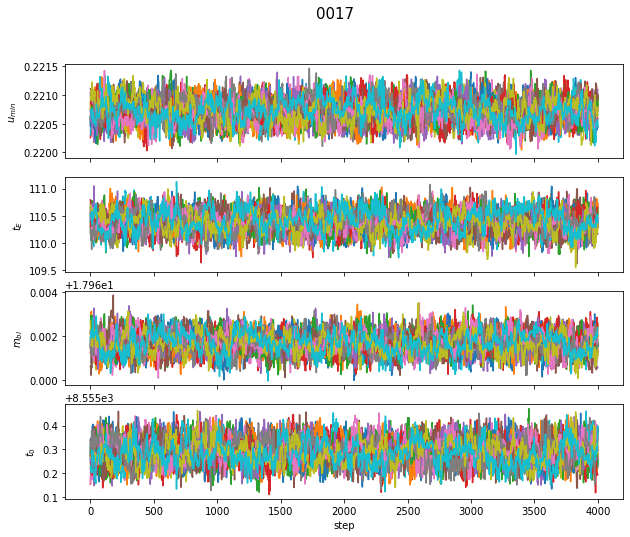

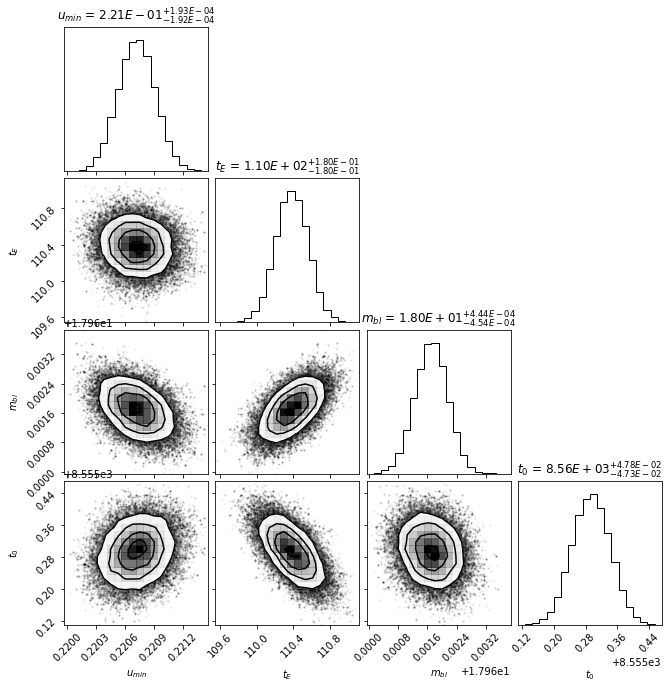

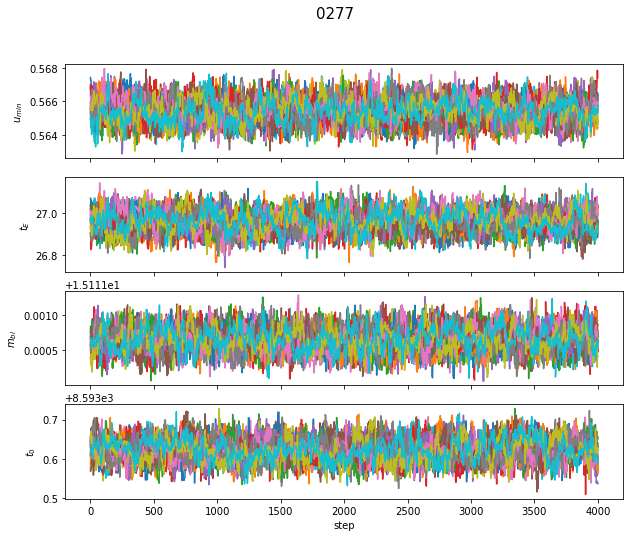

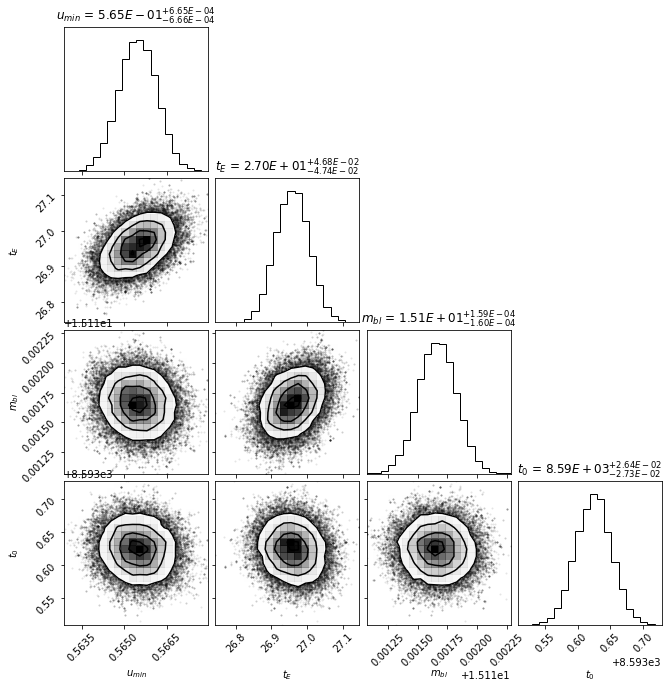

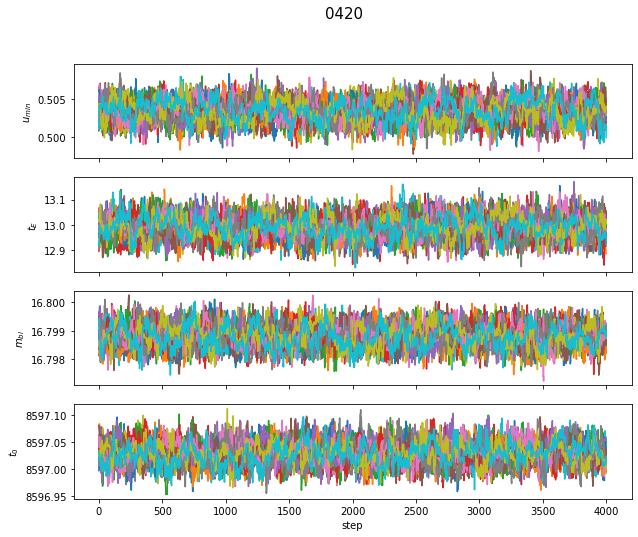

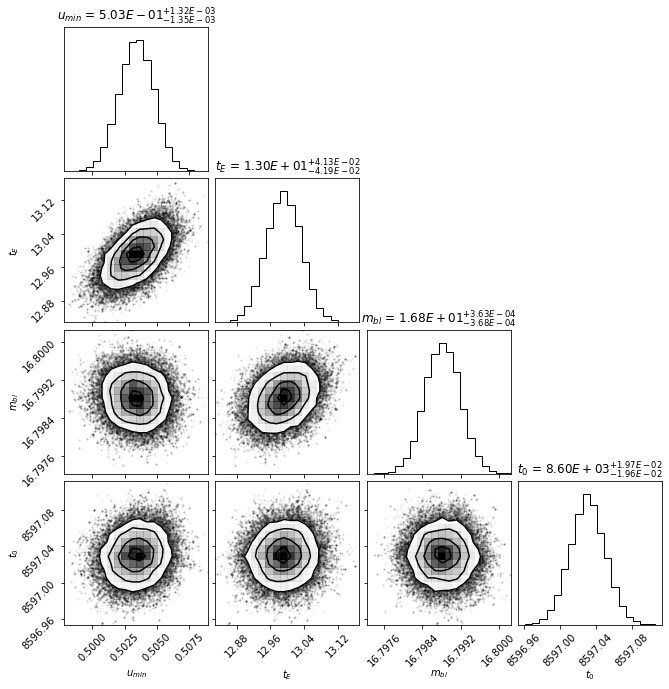

In [7]:
# temp = {}

for name in Data.keys():
    data = Data[name]
    x = data[:,0] - 245e4
    y = data[:,1]
    s = data[:,2]
    
    x=np.array(x,dtype=float)
    y=np.array(y,dtype=float)
    s=np.array(s,dtype=float)
    data = x,y,s
    
    
    ndim = 4
    nwalk = 20
    nburn = 400
    nmain = 4000
    
    f_src_guess = np.nanmean(y[(x>7400) & (x<8000)])
    params = [uminlist[names.index(name)],tElist[names.index(name)],m_bllist[names.index(name)], t_0list[names.index(name)]]
    # list of parameter names, for corner()
    #umin,tE, m_bl, t_0 = [0.036, 421, 17.99, 8600]
    plab = ['$u_{min}$','$t_E$','$m_{bl}$','$t_0$']

    # set up walkers by perturbing p0
    p0 = np.array(params)
    pstart = np.array([p0 + 1.0e-4*np.random.normal(size=ndim) for i in range(nwalk)])
    pstart = np.array(pstart,dtype=float)

    # set up the sampler
    sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob,args=(data,))

    # burn-in run
    print('burn-in run')
    pos,prob,state = sampler.run_mcmc(pstart,nburn)

    # main run
    print('main run')
    sampler.reset()
    res = sampler.run_mcmc(pos,nmain)

    # process
    samples = sampler.get_chain(flat=True)
    #temp[Name] = samples
    # plot the chains as a way to check for convergence
    f,ax = plt.subplots(ndim,1,figsize=(10,8),sharex=True)
    for idim in range(ndim):
        for iwalk in range(nwalk):
            ax[idim].plot(sampler.chain[iwalk,:,idim])
        ax[idim].set_ylabel(plab[idim])
    f.suptitle(name,fontsize = 15)
    ax[-1].set_xlabel('step')
    f.show()

    # corner plot
    f = corner.corner(samples, show_titles = True, labels = plab, title_fmt = ".2E")
    #f.show()
    # f.savefig('sample_corner.pdf',bbox_inches='tight')

# Creating a model taking blending into account

In [14]:
def xi(param):
    'X^2 to mininize to find parameters'
    #m_bl being the baseline magnitude
    umin,tE, m_bl, t_0, f_bl = param 
    
    u = np.sqrt(umin**2 + ((x-t_0)/tE)**2)
    A = u**2 + 2
    A /= (u*np.sqrt((u**2)+4))
    #m_mod refers to m observed as predicted by our model 
    m_mod = m_bl - 2.5*np.log10(f_bl*(A-1)+1)
    
    if (tE < 1 or umin < 1e-4):
        return 1e8
    
    tot = 0
    for i in range(len(y)):
        tot += ((y[i] - m_mod[i])**2)/s[i]**2 
    return tot

In [15]:
## For testing purposes
uminlist = list(set(uminlist))
tElist = list(set(tElist))
m_bllist = list(set(m_bllist))
t_0list = list(set(t_0list))
print(uminlist)
print(tElist)
print(m_bllist)
print(t_0list)

[0.22072320120867134, 0.5654724876707333, 0.5037137940674383]
[26.958989346407648, 12.851161183632032, 110.38087810793418]
[16.79513317358006, 17.961688598283516, 15.111664528868818]
[8593.624116883835, 8555.29617876318, 8597.027576912858]


In [16]:
# Creating lists of parameters to call later
uminlist_bl = []
tElist_bl = []
m_bllist_bl = []
t_0list_bl = []
f_bllist_bl = []

      fun: 28469.91286605026
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.25991243,  0.        , -2.36614122, -0.12440888,  4.53983376])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 552
      nit: 75
     njev: 92
   status: 0
  success: True
        x: array([3.64136211e-02, 4.21242230e+02, 1.79978036e+01, 8.55773353e+03,
       1.51780654e-01])
[3.64136211e-02 4.21242230e+02 1.79978036e+01 8.55773353e+03
 1.51780654e-01]


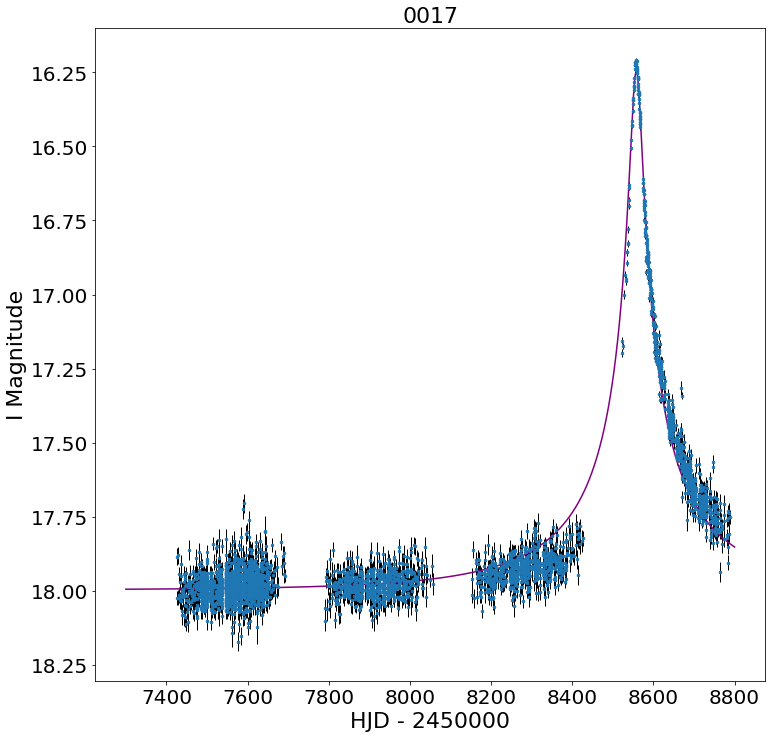

      fun: 1894.523541552846
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.05679052e-02,  3.77440270e-03, -1.45587352e-01,  2.91014915e-03,
       -2.75836122e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1626
      nit: 172
     njev: 271
   status: 0
  success: True
        x: array([5.65472561e-01, 2.69589507e+01, 1.51116646e+01, 8.59362414e+03,
       1.00000000e+00])
[5.65472561e-01 2.69589507e+01 1.51116646e+01 8.59362414e+03
 1.00000000e+00]


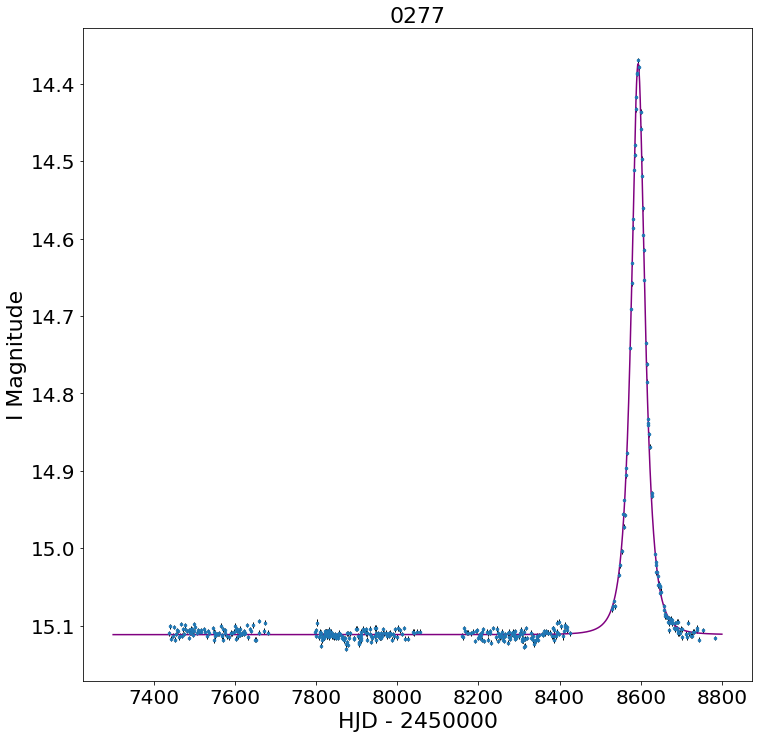

      fun: 1071.0023510433325
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.46428646e-02,  1.29602984e-03,  1.52112976e-02,  2.36449618e-03,
       -1.06843503e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 792
      nit: 101
     njev: 132
   status: 0
  success: True
        x: array([5.03345155e-01, 1.29889724e+01, 1.67988196e+01, 8.59703002e+03,
       1.00000000e+00])
[5.03345155e-01 1.29889724e+01 1.67988196e+01 8.59703002e+03
 1.00000000e+00]


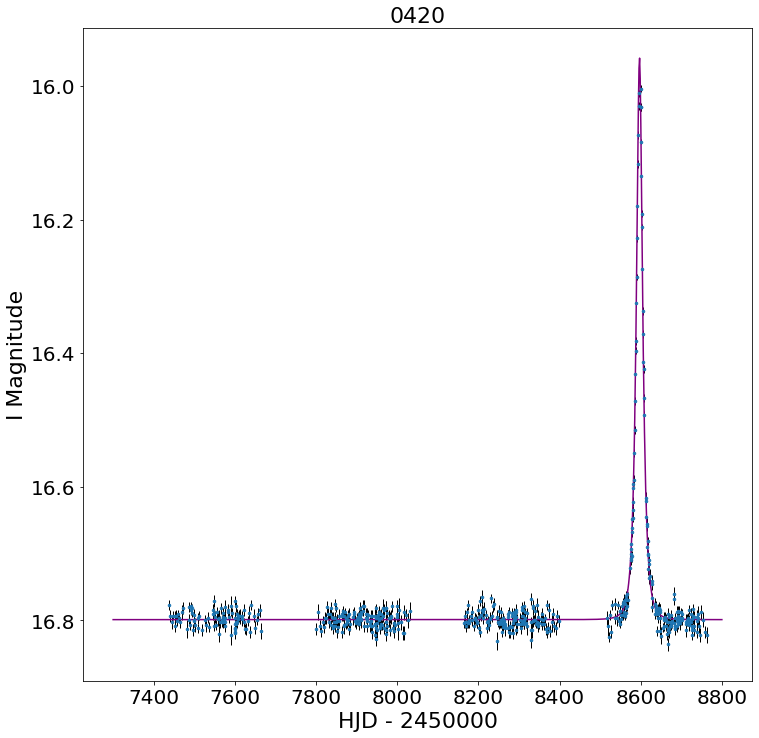

In [17]:
for name in Data.keys():
    d = Data[name]
    x = d[:,0] - 245e4
    y = d[:,1]
    s = d[:,2]
    

    # change the size of the plot to a square
    plt.rcParams["figure.figsize"] = (12, 12)
    
    
    # Might want to plot error barrs in scatterplot
    plt.errorbar(x, y, yerr = s, fmt = '.', ms = 5, elinewidth = 1, ecolor = 'black')
    
    #Optimizing using non blending model as starting parameters
    #Creating bounds on certain parameters that would otherwise yield unexpected results
    #Uisng minimize instead of fmin as minimize allows better control of bounds
    bounds = ((1e-4, 1e5),(1, 1e8),(1, 1e8), (1,1e8),(0,1))
    opt = optimize.minimize(xi,[uminlist[names.index(name)], tElist[names.index(name)], 
                                     m_bllist[names.index(name)], t_0list[names.index(name)], 1], bounds = bounds)
    #opt = optimize.fmin(xi,opt)
    #opt = np.array(opt)
    #opt = optimize.fmin(xi,opt)
    print(opt)
    opt = np.array(opt.x)
    print(opt)

    xlist = np.linspace(7300, 8800, 1000)
    #umin,tE, m_bl, t_0 = [0.036, 421, 17.99, 8600]
    umin,tE, m_bl, t_0, f_bl = opt
    uminlist_bl.append(umin)
    tElist_bl.append(tE)
    m_bllist_bl.append(m_bl)
    t_0list_bl.append(t_0)
    f_bllist_bl.append(f_bl)

    u=[]
    A=[]
    m_mod=[]
    for i in range(len(xlist)):
        u.append(np.sqrt(umin**2 + ((xlist[i]-t_0)/tE)**2))
        A.append((u[i]**2 + 2)/(u[i]*np.sqrt((u[i]**2)+4)))
        m_mod.append(m_bl - 2.5*np.log10(f_bl*(A[i]-1)+1))
    plt.gca().invert_yaxis()
    
    plt.plot(xlist,m_mod,color='purple')
    plt.title(name,fontsize = 22)
    plt.ylabel('I Magnitude', fontsize = 22)
    plt.xlabel('HJD - 2450000', fontsize = 22)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()

In [18]:
print("Results without blending:")
for i in range(len(names)):
    print("\tEvent {}".format(names[i]))
    print("\t\tu min = {}".format(uminlist[i]))
    print("\t\tEinstein time = {} days".format(tElist[i]))
    print("\t\tBaseline Intensity = {}".format(m_bllist[i]))
    print("\t\tt0 min = {}".format(t_0list[i]))
    
print("\n\n")    
print("Results with blending:")
for i in range(len(names)):
    print("\tEvent {}".format(names[i]))
    print("\t\tu min = {}".format(uminlist_bl[i]))
    print("\t\tEinstein time = {}".format(tElist_bl[i]))
    print("\t\tBaseline Intensity = {}".format(m_bllist_bl[i]))
    print("\t\tt0 = {}".format(t_0list_bl[i]))
    print("\t\tblending ratio = {}".format(f_bllist_bl[i]))

Results without blending:
	Event 0017
		u min = 0.22072320120867134
		Einstein time = 26.958989346407648 days
		Baseline Intensity = 16.79513317358006
		t0 min = 8593.624116883835
	Event 0277
		u min = 0.5654724876707333
		Einstein time = 12.851161183632032 days
		Baseline Intensity = 17.961688598283516
		t0 min = 8555.29617876318
	Event 0420
		u min = 0.5037137940674383
		Einstein time = 110.38087810793418 days
		Baseline Intensity = 15.111664528868818
		t0 min = 8597.027576912858



Results with blending:
	Event 0017
		u min = 0.03641362112700476
		Einstein time = 421.2422303515094
		Baseline Intensity = 17.997803567733715
		t0 = 8557.733531152251
		blending ratio = 0.1517806535001497
	Event 0277
		u min = 0.5654725608253313
		Einstein time = 26.958950684742966
		Baseline Intensity = 15.11166459171427
		t0 = 8593.624136175556
		blending ratio = 1.0
	Event 0420
		u min = 0.5033451546553176
		Einstein time = 12.988972355463932
		Baseline Intensity = 16.798819569140726
		t0 = 8597.03002

In [12]:
def valuetest(param):
    umin,tE, m_bl, t_0, f_bl = param
    if (tE < 1 or umin < 1e-4 or f_bl > 1 or f_bl < 0):
        return -np.inf
    else: return 0

In [14]:
def lnprob(param,dat):
    x,y,sig = dat
    lp = valuetest(param)
    if lp == -np.inf:
        return -np.inf
    else: return -0.5*xi(param)

burn-in run
main run


C:\Users\aryal\anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\aryal\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


burn-in run
main run


C:\Users\aryal\anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\aryal\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


burn-in run
main run


C:\Users\aryal\anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


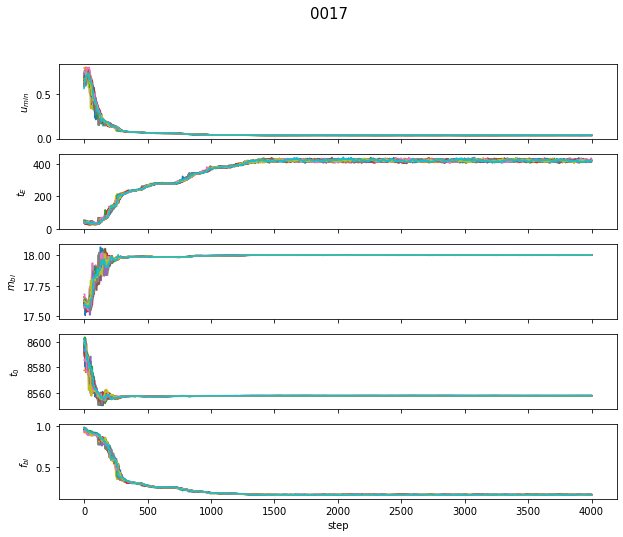

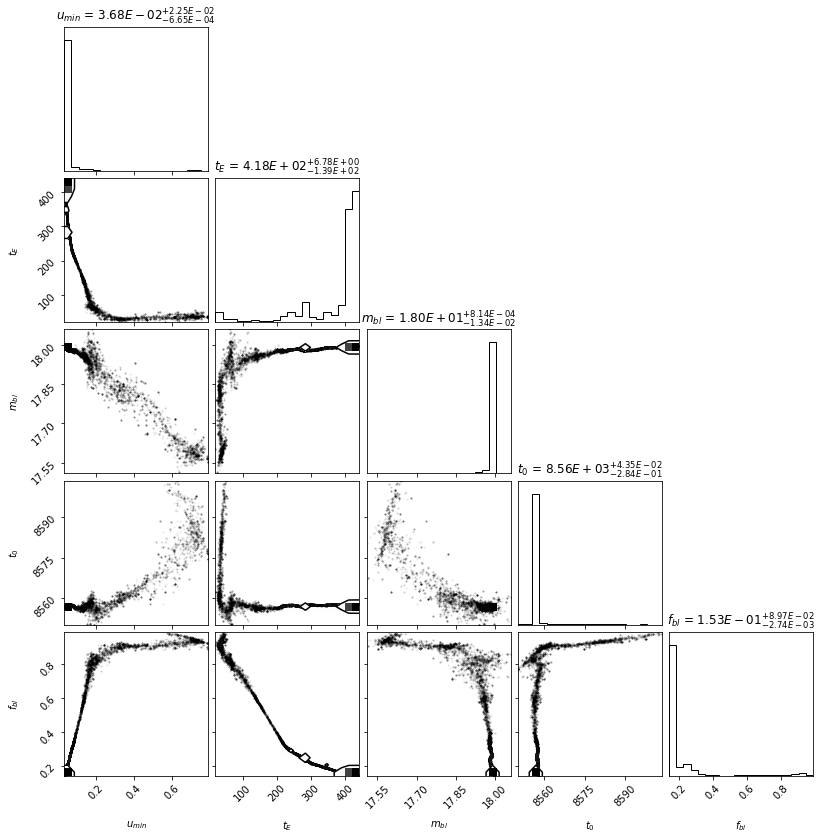

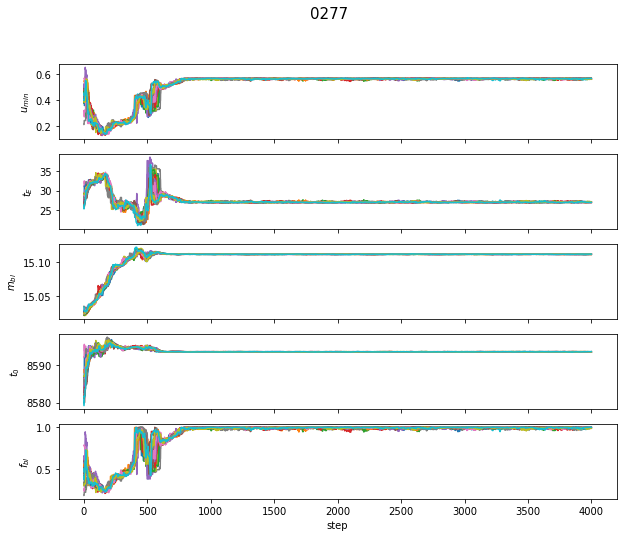

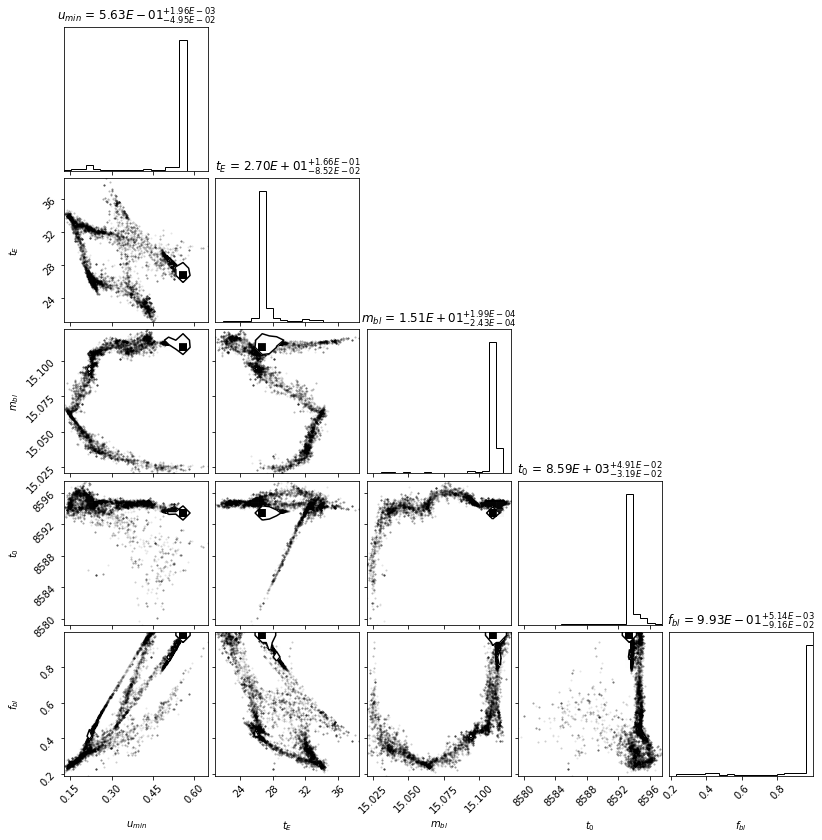

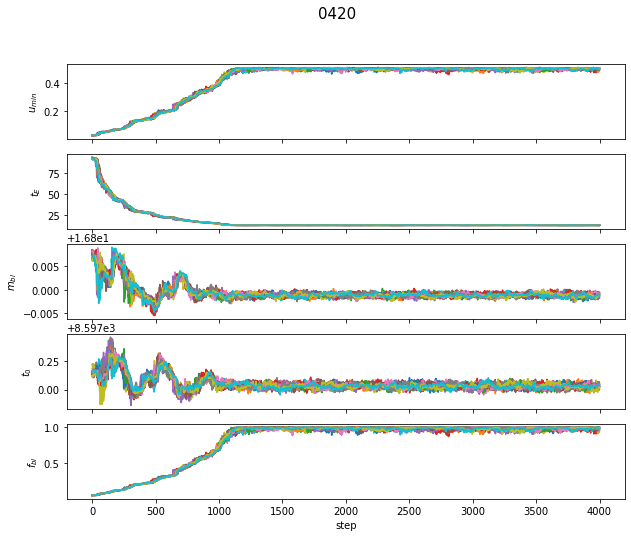

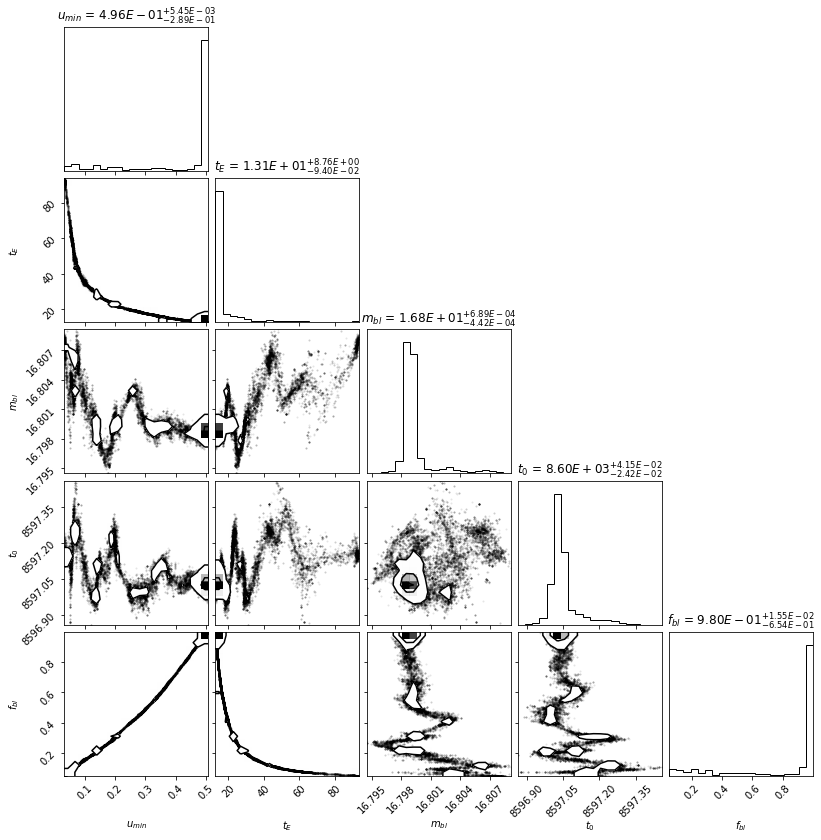

In [15]:
# temp = {}

for name in Data.keys():
    data = Data[name]
    x = data[:,0] - 245e4
    y = data[:,1]
    s = data[:,2]
    
    x=np.array(x,dtype=float)
    y=np.array(y,dtype=float)
    s=np.array(s,dtype=float)
    data = x,y,s
    
    
    ndim = 5
    nwalk = 20
    nburn = 400
    nmain = 4000
    
    params = [uminlist[names.index(name)],tElist[names.index(name)],m_bllist[names.index(name)], t_0list[names.index(name)],f_bllist_bl[names.index(name)]]
    # list of parameter names, for corner()
    #umin,tE, m_bl, t_0 = [0.036, 421, 17.99, 8600]
    plab = ['$u_{min}$','$t_E$','$m_{bl}$','$t_0$','$f_{bl}$']

    # set up walkers by perturbing p0
    p0 = np.array(params)
    pstart = np.array([p0 + 1.0e-4*np.random.normal(size=ndim) for i in range(nwalk)])
    pstart = np.array(pstart,dtype=float)

    # set up the sampler
    sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob,args=(data,))

    # burn-in run
    print('burn-in run')
    pos,prob,state = sampler.run_mcmc(pstart,nburn)

    # main run
    print('main run')
    sampler.reset()
    res = sampler.run_mcmc(pos,nmain)

    # process
    samples = sampler.get_chain(flat=True)
    #temp[Name] = samples
    # plot the chains as a way to check for convergence
    f,ax = plt.subplots(ndim,1,figsize=(10,8),sharex=True)
    for idim in range(ndim):
        for iwalk in range(nwalk):
            ax[idim].plot(sampler.chain[iwalk,:,idim])
        ax[idim].set_ylabel(plab[idim])
    f.suptitle(name,fontsize = 15)
    ax[-1].set_xlabel('step')
    f.show()

    # corner plot
    f = corner.corner(samples, show_titles = True, labels = plab, title_fmt = ".2E")
    #f.show()
    # f.savefig('sample_corner.pdf',bbox_inches='tight')